# Logitstic Regression

In [1]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from src.logreg import LogReg
import src.utils as utils

### Without outliers

In [2]:
df = pd.read_csv("data/diamonds.csv")
X_train, X_test, y_train, y_test = utils.preprocessing_LOS(df)

First, we train a Logistic Regression with the default parameters, and see what is capable of.  
Note: L2 (Ridge) Regularization is used.

In [3]:
model = LogReg()
model.cross_validation(X_train, y_train, 5, 0.2)

Performing cross validation


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.5s remaining:    6.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    4.6s remaining:    3.0s


Cross validation (accuracy) scores:
	mean: 0.6894492368944923 std: 0.005058475593713242


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished


In [4]:
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
model.fit(X_train2, y_train2)
model.compute_metrics(X_val, y_val)

{'accuracy': 0.6983410749834108,
 'precision': 0.6492027334851936,
 'recall': 0.47818791946308725,
 'f1': 0.5507246376811594}

Not bad for a simple model, but an exploration on the best hyperparameters will certainly improve these metrics.  
First, let's make sure regularization made a good job by showing the values of the coefficients (the weights).

Total number of weights: 45, (9 per class)


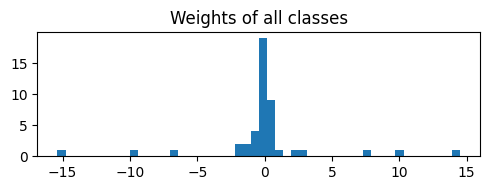

In [5]:
import matplotlib.pyplot as plt
import numpy as np

weights = model.coef_

weights_flattened = weights.flatten()
print(f"Total number of weights: {len(weights_flattened)}, ({len(weights_flattened) // 5} per class)")

plt.figure(figsize=(5, 2))
plt.hist(weights_flattened, bins=50)
plt.title('Weights of all classes')
plt.tight_layout()
plt.show()

Most of the coefficients have a low value (between -3 and 3), which is what we wanted with regularization.

Now we will search the best parameters.

In [3]:
param_grid = [
    {
        "penalty": ["l1"],
        "lam": [0.01, 0.1, 1, 10],
        "solver": ["liblinear"] # only solver that supports l1
    },
    {
        "penalty": [None, "l2"],
        "lam": [0.01, 0.1, 1, 10]
    }
]

grid_search = GridSearchCV(LogReg(), param_grid, cv=5, scoring="accuracy", return_train_score=True, n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogReg(), n_jobs=-1,
             param_grid=[{'lam': [0.01, 0.1, 1, 10], 'penalty': ['l1'],
                          'solver': ['liblinear']},
                         {'lam': [0.01, 0.1, 1, 10], 'penalty': [None, 'l2']}],
             return_train_score=True, scoring='accuracy')

In [4]:
sorted(zip(grid_search.cv_results_["mean_test_score"], grid_search.cv_results_["params"]), reverse=True, key=lambda x: x[0])

[(0.6859768033835796, {'lam': 0.01, 'penalty': 'l2'}),
 (0.6859768033835796, {'lam': 0.1, 'penalty': 'l2'}),
 (0.6859768033835796, {'lam': 1, 'penalty': 'l2'}),
 (0.6859768033835796, {'lam': 10, 'penalty': 'l2'}),
 (0.6851007077574713, {'lam': 0.01, 'penalty': None}),
 (0.6851007077574713, {'lam': 0.1, 'penalty': None}),
 (0.6851007077574713, {'lam': 1, 'penalty': None}),
 (0.6851007077574713, {'lam': 10, 'penalty': None}),
 (0.6827909168510866, {'lam': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}),
 (0.6827909168510866, {'lam': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}),
 (0.6827909168510866, {'lam': 1, 'penalty': 'l1', 'solver': 'liblinear'}),
 (0.6827909168510866, {'lam': 10, 'penalty': 'l1', 'solver': 'liblinear'})]

Unexpectedly, changing the paramters didn't improve the accuracy. We will continue with l2 regularization and a strenght (lambda) of 1, which are the default parameters.  
We will try different things to see if it can be imrpoved. First, we experiment with one-hot encoding.

In [10]:
X_train, X_test, y_train, y_test = utils.preprocessing_HOS(df)

model = LogReg()
model.cross_validation(X_train, y_train, 5, 0.2)

Performing cross validation


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.2s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    5.3s remaining:    3.5s


Cross validation (accuracy) scores:
	mean: 0.6887974515529599 std: 0.0011710509689467838


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.6s finished


In [11]:
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
model.fit(X_train2, y_train2)
model.compute_metrics(X_val, y_val)

{'accuracy': 0.6902044066896735,
 'precision': 0.6308411214953271,
 'recall': 0.46551724137931033,
 'f1': 0.5357142857142857}

That didn't change much the metrics. Now we try to create new features, projections of the existing features to a higher space. We will project the variables that were initially numerical: carat, depth, table, price, x, y and z.

In [34]:
from sklearn.preprocessing import PolynomialFeatures

df_new = df.copy()
numerical = ["carat", "depth", "table", "price", "x", "y", "z"]
poly = PolynomialFeatures(2)
df_new = df_new.drop(numerical, axis=1)
new_features = poly.fit_transform(df[numerical])[:,1:] # drop first column (1)
feature_names = poly.get_feature_names_out(numerical)[1:]
df_new = pd.concat([df_new, pd.DataFrame(new_features, columns=feature_names)], axis=1)
X_train, X_test, y_train, y_test = utils.preprocessing_LOS(df_new)
X_train.head()

,color,clarity,carat,depth,table,price,x,y,z,carat^2,...,price^2,price x,price y,price z,x^2,x y,x z,y^2,y z,z^2
0,0.317336,2.358939,-1.103109,0.460126,-1.114729,-0.808480,-1.271102,-1.242564,-1.217847,-0.869034,...,-0.599464,-0.793116,-0.791753,-0.791489,-1.187659,-1.177835,-1.169527,-1.167088,-1.159108,-1.147651
1,-0.277744,0.529144,0.037343,-0.835567,1.367566,-0.180193,0.245358,0.210501,0.139712,-0.185188,...,-0.378811,-0.227007,-0.231262,-0.240441,0.158682,0.141487,0.105635,0.123929,0.088379,0.052018
2,-0.277744,-1.300651,1.585098,-0.280270,-1.114729,1.175682,1.526152,1.488374,1.464160,1.643670,...,0.838287,1.249685,1.236903,1.232846,1.603763,1.581371,1.569524,1.557479,1.546494,1.528244
3,0.912417,-1.300651,0.145957,-0.187721,-1.114729,-0.153543,0.337575,0.385693,0.338379,-0.090688,...,-0.364645,-0.193663,-0.187240,-0.193389,0.253306,0.278679,0.254824,0.303958,0.280034,0.254197
4,-0.277744,1.139075,0.797644,-0.187721,1.864025,1.701749,0.860139,0.828827,0.818491,0.583580,...,1.583171,1.505365,1.493633,1.492077,0.817125,0.800379,0.796060,0.782737,0.778918,0.770852


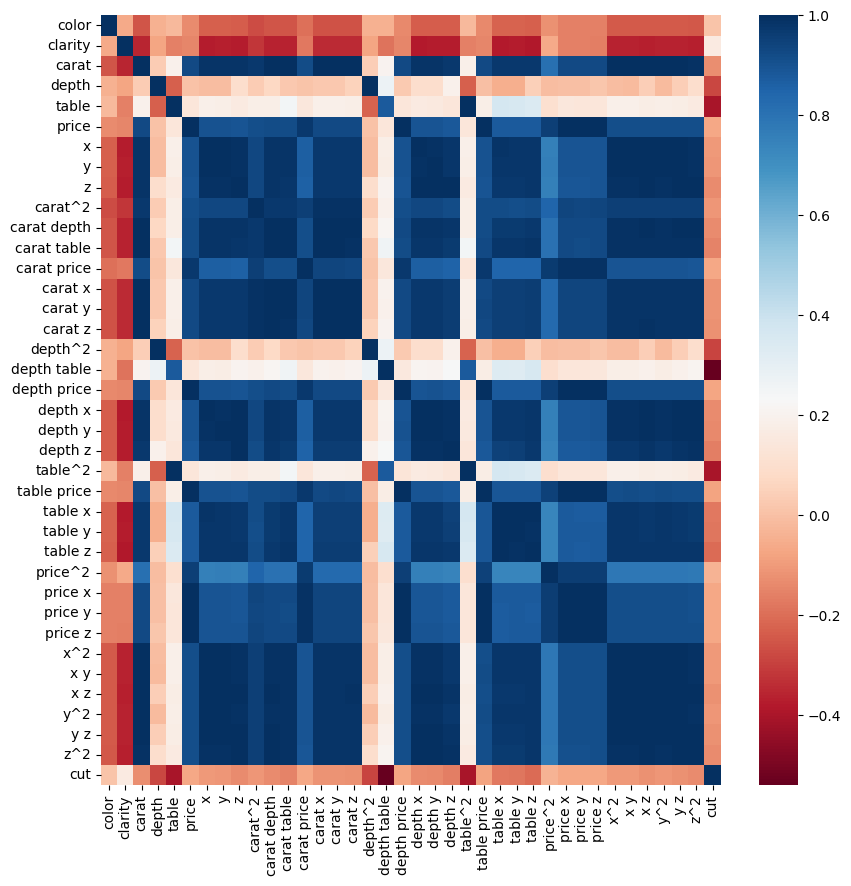

In [37]:
import seaborn as sns

df_temp = pd.concat([X_train, y_train], axis=1)
corr = df_temp.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, cmap="RdBu")
plt.show()

As expected, variations of each feature (eg. x, x^2, xy...) have high correlation between themselves.

In [38]:
model = LogReg()
model.cross_validation(X_train, y_train, 5, 0.2)

Performing cross validation


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   13.8s remaining:   20.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   14.2s remaining:    9.5s


Cross validation (accuracy) scores:
	mean: 0.7206530395540217 std: 0.0012830417811090684


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.6s finished


In [39]:
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
model.fit(X_train2, y_train2)
model.compute_metrics(X_val, y_val)

{'accuracy': 0.7195380939739846,
 'precision': 0.6872037914691943,
 'recall': 0.5,
 'f1': 0.5788423153692615}

Altough the accuracy did increase a bit, the recall remains low. We will try to project the features up to degree 3, and see if something improves.

In [6]:
df_new2 = df.copy()
numerical = ["carat", "depth", "table", "price", "x", "y", "z"]
poly = PolynomialFeatures(3)
df_new2 = df_new2.drop(numerical, axis=1)
new_features = poly.fit_transform(df[numerical])[:,1:] # drop first column (1)
feature_names = poly.get_feature_names_out(numerical)[1:]
df_new2 = pd.concat([df_new2, pd.DataFrame(new_features, columns=feature_names)], axis=1)
X_train, X_test, y_train, y_test = utils.preprocessing_LOS(df_new2)
X_train.shape

(37988, 121)

In [7]:
model = LogReg()
model.cross_validation(X_train, y_train, 5, 0.2)

Performing cross validation


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   35.8s remaining:   53.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   35.9s remaining:   23.9s


Cross validation (accuracy) scores:
	mean: 0.7331666227954725 std: 0.0039304672713724965


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   39.8s finished


In [8]:
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
model.fit(X_train2, y_train2)
model.compute_metrics(X_val, y_val)

{'accuracy': 0.7313766780731772,
 'precision': 0.6818181818181818,
 'recall': 0.5400981996726678,
 'f1': 0.6027397260273972}

Recall stays low, so we will make sure that all classes are predicted with a similar distribution as they have in the training set.

In [9]:
result_df = pd.DataFrame({"y_val": y_val, "y_pred": model.predict(X_val)})
result_counts = result_df.apply(pd.Series.value_counts)
result_counts

,y_val,y_pred
4,3264,3736
3,1933,1862
2,1734,1504
1,611,484
0,56,12


The cause for a low recall could be that classes 0 - 2 (specially 0) are being predicted with less frequency than they should. To solve that, we will set the `class_weight` parameter to `balanced`.

In [10]:
model2 = LogReg(class_weight="balanced")
model2.cross_validation(X_train, y_train, 5, 0.2)

Performing cross validation


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   39.5s remaining:   59.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   40.6s remaining:   27.1s


Cross validation (accuracy) scores:
	mean: 0.6848117925769939 std: 0.0025836520632149273


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   41.9s finished


In [11]:
model2.fit(X_train2, y_train2)
model2.compute_metrics(X_val, y_val)

{'accuracy': 0.684127401947881,
 'precision': 0.4559902200488998,
 'recall': 0.6104746317512275,
 'f1': 0.522043386983905}

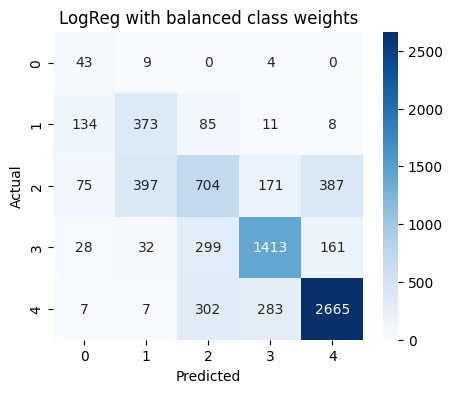

In [29]:
plt.figure(figsize=(5, 4))
sns.heatmap(model2.conf_matrix(X_val, y_val), annot=True, cmap="Blues", fmt="g")
plt.title("LogReg with balanced class weights")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [13]:
result_df = pd.DataFrame({"y_val": y_val, "y_pred": model2.predict(X_val)})
result_counts = result_df.apply(pd.Series.value_counts)
result_counts

,y_val,y_pred
4,3264,3221
3,1933,1882
2,1734,1390
1,611,818
0,56,287


We got a significant decrease in precision. Moreover, we observe that, despite training the model with balanced importance of the classes, class 0 is now overpredicted. Now we compare it with the previous model (which had no class weigths).

In [12]:
diff = model2.compare(model, X_val, y_val)

accuracy -0.04724927612529617
precision -0.225827961769282
recall 0.0703764320785597
f1 -0.08069633904349227
confusion matrix [[  36  -34   -1    0   -1]
 [ 129   43 -143  -18  -11]
 [  75  291 -153  -52 -161]
 [  28   31   34  -18  -75]
 [   7    3  149  108 -267]]


All metrics decreased except recall, that increased a bit.

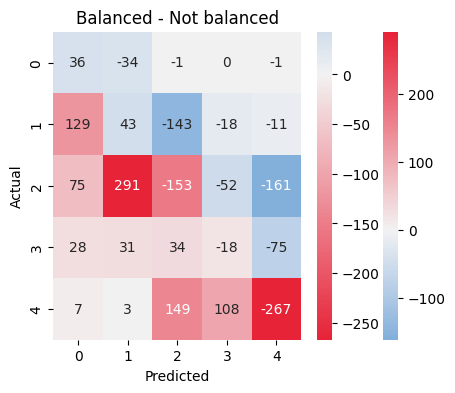

In [24]:
conf_mat_diff = diff["confusion matrix"]

mask = np.eye(conf_mat_diff.shape[0], dtype=bool)
cmap_diag = sns.diverging_palette(250, 10, s=90, l=50, as_cmap=True)
cmap_offdiag = sns.diverging_palette(10, 250, s=90, l=50, as_cmap=True)

plt.figure(figsize=(5, 4))
sns.heatmap(conf_mat_diff, mask=mask, annot=True, fmt="d", cmap=cmap_diag, center=0)
sns.heatmap(conf_mat_diff, mask=~mask, annot=True, fmt="d", cmap=cmap_offdiag, center=0)
plt.title("Balanced - Not balanced")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

The difference confusion matrix shows that the actual class 0 was much more correctly predicted (look at first row), but because the model had a trend to predict all classes as 0 more often (look at first column).  
Another observation is that class 2 was less predicted as being class 3 or 4, but more at being class 0 or 1, and overall less predicted as the class 2 it was.

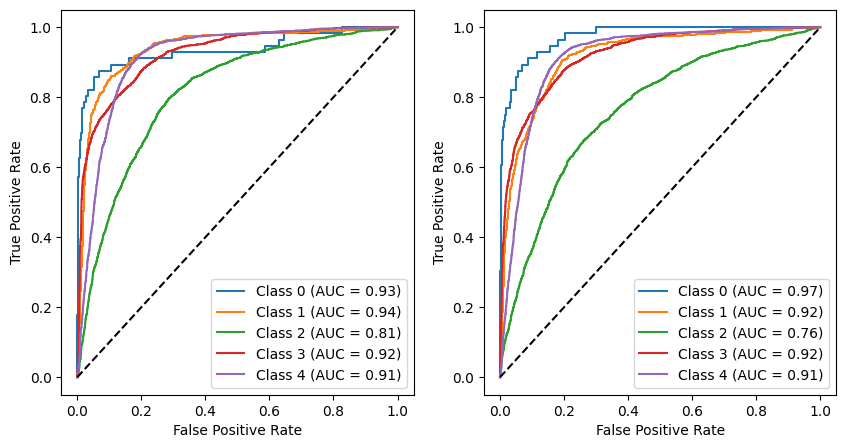

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
model.roc_curve(X_val, y_val, ax[0])
model2.roc_curve(X_val, y_val, ax[1])
plt.show()

We can't see much difference in the ROC curves of both, except the two ovservations we've just made with the difference confusion matrix: class 0 is better predicted and class 2 is worse predicted.  
We conclude it's not worth to set `class_weigth = "balanced"`.

In [31]:
X_train, X_test, y_train, y_test = utils.preprocessing_LOS(df)
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
model = LogReg()
model.fit(X_train2, y_train2)
model.compute_metrics(X_val, y_val)

{'accuracy': 0.6817583574624901,
 'precision': 0.6275395033860045,
 'recall': 0.45499181669394434,
 'f1': 0.5275142314990512}